# Regression Deep Learning Model for Ames Iowa Housing Prices Using TensorFlow Take 5
### David Lowe
### February 27, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Ames Iowa Housing Prices dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Many factors can influence a home's purchase price. This Ames Housing dataset contains 79 explanatory variables describing every aspect of residential homes in Ames, Iowa. The goal is to predict the final price of each home.

In iteration Take1, we established the baseline mean squared error for further takes of modeling.

In iteration Take2, we converted some of the categorical variables from nominal to ordinal and observed the effects of the change.

In iteration Take3, we examined the feature selection technique of attribute importance ranking by using the Gradient Boosting algorithm. By selecting only the most important attributes, we decreased the processing time and maintained a similar level of RMSE compared to the baseline.

In iteration Take4, we examined the feature selection technique of recursive feature elimination (RFE) by using the Gradient Boosting algorithm. By selecting up to 100 attributes, we decreased the processing time and maintained a similar level of RMSE compared to the baseline.

In this Take5 iteration, we will construct several Multilayer Perceptron (MLP) models with one, two, and three hidden layers. We will observe how the different model architectures affect the RMSE metric.

ANALYSIS: In iteration Take1, the baseline performance of the machine learning algorithms achieved an average RMSE of 31,172. Two algorithms (Ridge Regression and Gradient Boosting) achieved the top RMSE metrics after the first round of modeling. After a series of tuning trials, Gradient Boosting turned in the best overall result and achieved an RMSE metric of 24,165. By using the optimized parameters, the Gradient Boosting algorithm processed the test dataset with an RMSE of 21,067, which was even better than the prediction from the training data.

In iteration Take2, Gradient Boosting achieved an RMSE metric of 23,612 with the training dataset and processed the test dataset with an RMSE of 21,130. Converting the nominal variables to ordinal did not have a material impact on the prediction accuracy in either direction.

In iteration Take3, Gradient Boosting achieved an RMSE metric of 24,045 with the training dataset and processed the test dataset with an RMSE of 21,994. At the importance level of 99%, the attribute importance technique eliminated 222 of 258 total attributes. The remaining 36 attributes produced a model that achieved a comparable RMSE to the baseline model. The processing time for Take2 also reduced by 67.90% compared to the Take1 iteration.

In iteration Take4, Gradient Boosting achieved an RMSE metric of 23,825 with the training dataset and processed the test dataset with an RMSE of 21,898. The RFE technique eliminated 208 of 258 total attributes. The remaining 50 attributes produced a model that achieved a comparable RMSE to the baseline model. The processing time for Take3 also reduced by 1.8% compared to the Take1 iteration.

In this Take5 iteration, all models processed the test dataset and produced an RMSE near or around the 23,000 level. The two-layer model with 128 and 64 nodes (Model 2C) was able to achieve the best RMSE of 22,708 using the test dataset. All models eventually overfit, and the models with more layers overfit much faster than the simpler models.

CONCLUSION: For this iteration, the different model architectures produced similar RMSEs. For this dataset, we should consider experimenting with more regularization techniques.

Dataset Used: Kaggle Competition - House Prices: Advanced Regression Techniques

Dataset ML Model: Regression with numerical and categorical attributes

Dataset Reference: https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

One potential source of performance benchmarks: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Any deep-learning modeling project genrally can be broken down into about seven major tasks:

0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Retrieve GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Feb 21 16:13:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [0]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

In [5]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'mean_squared_error'
default_optimizer = tf.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.initializers.RandomNormal(seed=seedNum)
default_epoch = 500
default_batch = 32

Num GPUs Available:  1


In [0]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [0]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [0]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-ames-iowa-housing-prices/train.csv'
Xy_original = pd.read_csv(dataset_path, sep=',', index_col=0)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900


In [11]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [12]:
Xy_original.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [13]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64
Total number of NaN in the dataframe:  6965


## 1.b) Data Cleaning

In [0]:
# Dropping rows as recommended by the original report
Xy_original.query('GrLivArea < 4000', inplace=True)

# Impute the missing values as necessary
Xy_original['LotFrontage'].fillna(0, inplace=True)
Xy_original['Alley'].fillna('NoAlley', inplace=True)
Xy_original.Alley = Xy_original.Alley.astype('category')
Xy_original['MasVnrType'].fillna('NoMasonry', inplace=True)
Xy_original.MasVnrType = Xy_original.MasVnrType.astype('category')
Xy_original['MasVnrArea'].fillna(0, inplace=True)
Xy_original['BsmtQual'].fillna('NA', inplace=True)
Xy_original.BsmtQual = Xy_original.BsmtQual.astype('category')
Xy_original['BsmtCond'].fillna('NA', inplace=True)
Xy_original.BsmtCond = Xy_original.BsmtCond.astype('category')
Xy_original['BsmtExposure'].fillna('NA', inplace=True)
Xy_original.BsmtExposure = Xy_original.BsmtExposure.astype('category')
Xy_original['BsmtFinType1'].fillna('NA', inplace=True)
Xy_original.BsmtFinType1 = Xy_original.BsmtFinType1.astype('category')
Xy_original['BsmtFinType2'].fillna('NA', inplace=True)
Xy_original.BsmtFinType2 = Xy_original.BsmtFinType2.astype('category')
Xy_original['Electrical'].fillna('Unknown', inplace=True)
Xy_original.Electrical = Xy_original.Electrical.astype('category')
Xy_original['FireplaceQu'].fillna('NA', inplace=True)
Xy_original.FireplaceQu = Xy_original.FireplaceQu.astype('category')
Xy_original['GarageType'].fillna('NoGarage', inplace=True)
Xy_original.GarageType = Xy_original.GarageType.astype('category')
Xy_original['GarageYrBlt'].fillna(value=Xy_original['GarageYrBlt'].min(), inplace=True)
Xy_original.GarageYrBlt = Xy_original.GarageYrBlt.astype('category')
Xy_original['GarageFinish'].fillna('NA', inplace=True)
Xy_original.GarageFinish = Xy_original.GarageFinish.astype('category')
Xy_original['GarageQual'].fillna('NA', inplace=True)
Xy_original.GarageQual = Xy_original.GarageQual.astype('category')
Xy_original['GarageCond'].fillna('NA', inplace=True)
Xy_original.GarageCond = Xy_original.GarageCond.astype('category')
Xy_original['PoolQC'].fillna('NA', inplace=True)
Xy_original.PoolQC = Xy_original.PoolQC.astype('category')
Xy_original['Fence'].fillna('NoFence', inplace=True)
Xy_original.Fence = Xy_original.Fence.astype('category')
Xy_original['MiscFeature'].fillna('NoMiscFeature', inplace=True)
Xy_original.MiscFeature = Xy_original.MiscFeature.astype('category')

# Convert features with Y/N levels into category features
Xy_original.MSSubClass = Xy_original.MSSubClass.astype('category')
Xy_original.MSZoning = Xy_original.MSZoning.astype('category')
Xy_original.Street = Xy_original.Street.astype('category')
Xy_original.LotShape = Xy_original.LotShape.astype('category')
Xy_original.LandContour = Xy_original.LandContour.astype('category')
Xy_original.Utilities = Xy_original.Utilities.astype('category')
Xy_original.LotConfig = Xy_original.LotConfig.astype('category')
Xy_original.LandSlope = Xy_original.LandSlope.astype('category')
Xy_original.Neighborhood = Xy_original.Neighborhood.astype('category')
Xy_original.Condition1 = Xy_original.Condition1.astype('category')
Xy_original.Condition2 = Xy_original.Condition2.astype('category')
Xy_original.BldgType = Xy_original.BldgType.astype('category')
Xy_original.HouseStyle = Xy_original.HouseStyle.astype('category')
Xy_original.OverallQual = Xy_original.OverallQual.astype('category')
Xy_original.OverallCond = Xy_original.OverallCond.astype('category')
Xy_original.YearBuilt = Xy_original.YearBuilt.astype('category')
Xy_original.YearBuilt = Xy_original.YearBuilt.astype('category')
Xy_original.YearRemodAdd = Xy_original.YearRemodAdd.astype('category')
Xy_original.RoofStyle = Xy_original.RoofStyle.astype('category')
Xy_original.RoofMatl = Xy_original.RoofMatl.astype('category')
Xy_original.Exterior1st = Xy_original.Exterior1st.astype('category')
Xy_original.Exterior2nd = Xy_original.Exterior2nd.astype('category')
Xy_original.ExterQual = Xy_original.ExterQual.astype('category')
Xy_original.ExterCond = Xy_original.ExterCond.astype('category')
Xy_original.Foundation = Xy_original.Foundation.astype('category')
Xy_original.Heating = Xy_original.Heating.astype('category')
Xy_original.HeatingQC = Xy_original.HeatingQC.astype('category')
Xy_original.CentralAir = Xy_original.CentralAir.astype('category')
Xy_original.BsmtFullBath = Xy_original.BsmtFullBath.astype('category')
Xy_original.BsmtHalfBath = Xy_original.BsmtHalfBath.astype('category')
Xy_original.FullBath = Xy_original.FullBath.astype('category')
Xy_original.HalfBath = Xy_original.HalfBath.astype('category')
Xy_original.BedroomAbvGr = Xy_original.BedroomAbvGr.astype('category')
Xy_original.KitchenAbvGr = Xy_original.KitchenAbvGr.astype('category')
Xy_original.KitchenQual = Xy_original.KitchenQual.astype('category')
Xy_original.TotRmsAbvGrd = Xy_original.TotRmsAbvGrd.astype('category')
Xy_original.Functional = Xy_original.Functional.astype('category')
Xy_original.Fireplaces = Xy_original.Fireplaces.astype('category')
Xy_original.GarageCars = Xy_original.GarageCars.astype('category')
Xy_original.PavedDrive = Xy_original.PavedDrive.astype('category')
Xy_original.MoSold = Xy_original.MoSold.astype('category')
Xy_original.YrSold = Xy_original.YrSold.astype('category')
Xy_original.SaleType = Xy_original.SaleType.astype('category')
Xy_original.SaleCondition = Xy_original.SaleCondition.astype('category')

In [15]:
# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NoFence,NoMiscFeature,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NoFence,NoMiscFeature,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NoFence,NoMiscFeature,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NoFence,NoMiscFeature,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NoAlley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NoFence,NoMiscFeature,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NA,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NA,NoFence,NoMiscFeature,0,8,2007,WD,Normal,307000
8,60,RL,0.0,10382,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NA,NoFence,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NA,NoFence,NoMiscFeature,0,4,2008,WD,Abnorml,129900


In [16]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1456 non-null category
MSZoning         1456 non-null category
LotFrontage      1456 non-null float64
LotArea          1456 non-null int64
Street           1456 non-null category
Alley            1456 non-null category
LotShape         1456 non-null category
LandContour      1456 non-null category
Utilities        1456 non-null category
LotConfig        1456 non-null category
LandSlope        1456 non-null category
Neighborhood     1456 non-null category
Condition1       1456 non-null category
Condition2       1456 non-null category
BldgType         1456 non-null category
HouseStyle       1456 non-null category
OverallQual      1456 non-null category
OverallCond      1456 non-null category
YearBuilt        1456 non-null category
YearRemodAdd     1456 non-null category
RoofStyle        1456 non-null category
RoofMatl         1456 non-null category
Exterior1st      

In [17]:
Xy_original.describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,57.296016,10448.784341,101.526786,436.991071,46.677198,566.990385,1050.658654,1157.108516,343.532967,5.860577,1506.502060,471.568681,93.833791,46.221154,22.014423,3.418956,15.102335,2.055632,43.608516,180151.233516
std,33.877802,9860.763449,177.011773,430.255052,161.522376,442.197182,412.155715,369.307331,431.528915,48.688904,496.815378,211.986421,125.192349,65.352424,61.192248,29.357056,55.828405,35.383772,496.799265,76696.592530
min,0.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,42.000000,7538.750000,0.000000,0.000000,0.000000,222.500000,795.000000,882.000000,0.000000,0.000000,1128.000000,329.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129900.000000
50%,63.000000,9468.500000,0.000000,381.000000,0.000000,477.500000,990.500000,1086.000000,0.000000,0.000000,1458.500000,478.500000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000
75%,79.000000,11588.000000,163.250000,706.500000,0.000000,808.000000,1293.750000,1389.250000,728.000000,0.000000,1775.250000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000
max,313.000000,215245.000000,1600.000000,2188.000000,1474.000000,2336.000000,3206.000000,3228.000000,1818.000000,572.000000,3627.000000,1390.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,625000.000000


In [18]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64
Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [20]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (1456, 80) X_original.shape: (1456, 79) y_original.shape: (1456,)


In [0]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

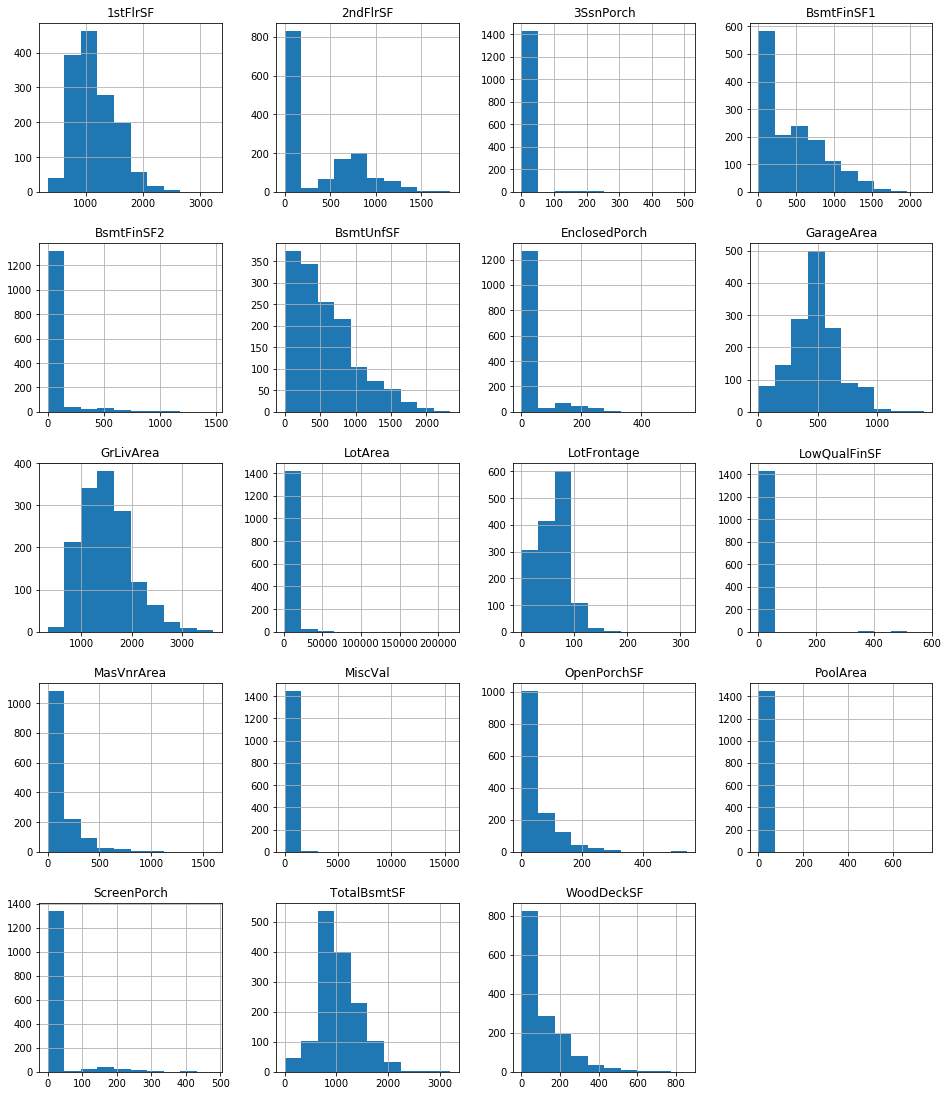

In [22]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [23]:
tobe_transformed_cols = []
for col in X_original.columns:
    if(pd.api.types.is_numeric_dtype(X_original[col])):
        tobe_transformed_cols.append(col)
print(tobe_transformed_cols)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [24]:
# Apply feature scaling and transformation
scaler = preprocessing.StandardScaler()
X_original[tobe_transformed_cols] = scaler.fit_transform(X_original[tobe_transformed_cols])
X_original.head(-10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,0.227483,-0.202770,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.533895,Gd,TA,PConc,Gd,TA,No,GLQ,0.625446,Unf,-0.289082,-0.943320,-0.472456,GasA,Ex,Y,SBrkr,-0.815613,1.183333,-0.120409,0.409745,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2,0.360672,TA,TA,Y,-0.749775,0.226218,-0.359882,-0.116501,-0.270606,-0.058115,NA,NoFence,NoMiscFeature,-0.087809,2,2008,WD,Normal
2,20,RL,0.670403,-0.086107,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,-0.573757,TA,TA,CBlock,Gd,TA,Gd,ALQ,1.257846,Unf,-0.289082,-0.640184,0.512947,GasA,Ex,Y,SBrkr,0.284120,-0.796357,-0.120409,-0.492308,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,-0.054591,TA,TA,Y,1.631381,-0.707503,-0.359882,-0.116501,-0.270606,-0.058115,NA,NoFence,NoMiscFeature,-0.087809,5,2007,WD,Normal
3,60,RL,0.316067,0.081281,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.341751,Gd,TA,PConc,Gd,TA,Mn,GLQ,0.113946,Unf,-0.289082,-0.300852,-0.317122,GasA,Ex,Y,SBrkr,-0.642256,1.211151,-0.120409,0.562772,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,0.643806,TA,TA,Y,-0.749775,-0.064613,-0.359882,-0.116501,-0.270606,-0.058115,NA,NoFence,NoMiscFeature,-0.087809,9,2008,WD,Normal
4,70,RL,0.079843,-0.091179,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,-0.573757,TA,TA,BrkTil,TA,Gd,No,ALQ,-0.513805,Unf,-0.289082,-0.061058,-0.715166,GasA,Gd,Y,SBrkr,-0.531200,0.956156,-0.120409,0.423840,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,0.804249,TA,TA,Y,-0.749775,-0.171761,4.086653,-0.116501,-0.270606,-0.058115,NA,NoFence,NoMiscFeature,-0.087809,2,2006,WD,Abnorml
5,60,RL,0.788515,0.386636,Pave,NoAlley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.404192,Gd,TA,PConc,Gd,TA,Av,GLQ,0.506871,Unf,-0.289082,-0.174169,0.228976,GasA,Ex,Y,SBrkr,-0.032798,1.644643,-0.120409,1.392339,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,1.719716,TA,TA,Y,0.784392,0.578277,-0.359882,-0.116501,-0.270606,-0.058115,NA,NoFence,NoMiscFeature,-0.087809,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,85,RL,0.375123,-0.207843,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,SFoyer,6,5,1966,1966,Gable,CompShg,VinylSd,VinylSd,None,-0.573757,TA,TA,CBlock,TA,TA,Gd,LwQ,-0.581230,Rec,3.594067,-1.282652,-0.574394,GasA,Gd,Y,SBrkr,-0.661217,-0.796357,-0.120409,-1.195023,1,0,1,0,3,1,TA,6,Typ,0,NA,Detchd,1990.0,Unf,1,-1.092750,TA,TA,Y,-0.749775,-0.707503,3.759702,-0.116501,-0.270606,-0.058115,NA,NoFence,NoMiscFeature,-0.087809,5,2007,WD,Normal
1447,20,RL,-1.691837,1.592028,Pave,NoAl

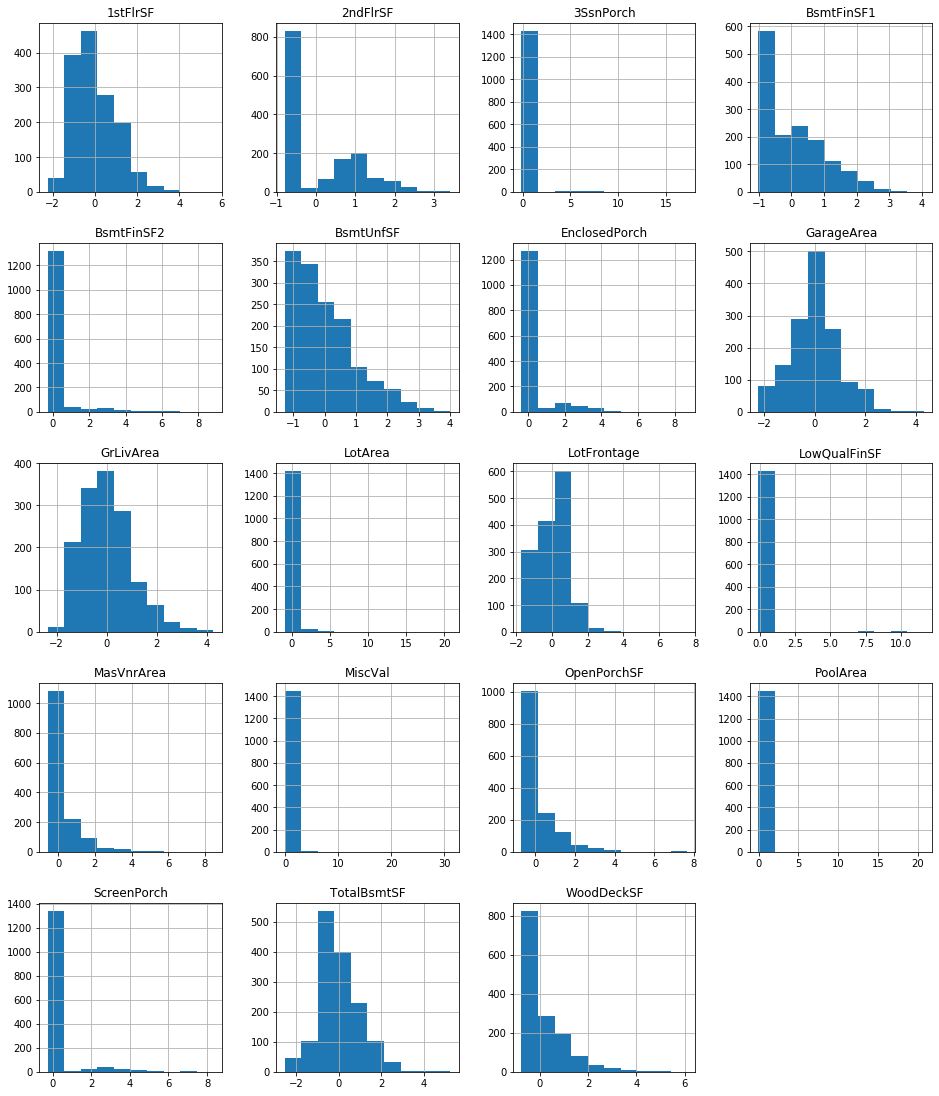

In [25]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

## 1.d) Splitting Data into Training and Test Sets

In [26]:
# Perform one-hot-encoding before splitting into trainig and test
X_original = pd.get_dummies(X_original)
print(X_original.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 1 to 1460
Columns: 654 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(19), uint8(635)
memory usage: 1.1 MB
None


In [27]:
X_encoded = X_original.to_numpy()
y_encoded = y_original.to_numpy()
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (1092, 654) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (1092,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (364, 654) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (364,) y_test.type: <class 'numpy.ndarray'>


In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Define the baseline model
def create_baseline_model():
    default_model = Sequential()
    default_model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

The minimum RMSE for the training dataset: 19929
The RMSE at the last epoch for the training dataset: 19929
The minimum RMSE for the test dataset: 24526
The RMSE at the last epoch for the test dataset: 24526
Total time for performing model fitting: 0:04:21.000314 



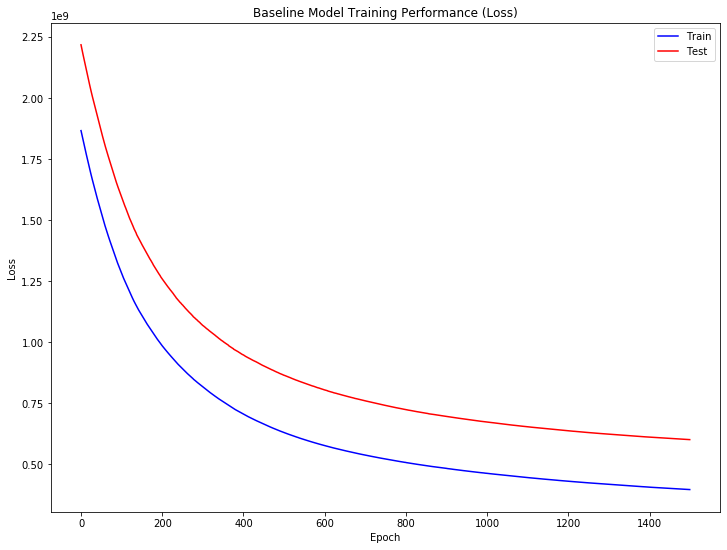

In [33]:
# Initialize the baseline model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model = create_baseline_model()
extra_epochs = 1500
baseline_hist = baseline_model.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                   validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', int(math.sqrt(min(baseline_hist.history['loss']))))
print('The RMSE at the last epoch for the training dataset:', int(math.sqrt(baseline_hist.history['loss'][-1])))
print('The minimum RMSE for the test dataset:', int(math.sqrt(min(baseline_hist.history['val_loss']))))
print('The RMSE at the last epoch for the test dataset:', int(math.sqrt(baseline_hist.history['val_loss'][-1])))
print('Total time for performing model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 500
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Explore Different Baseline Models

In [0]:
if (notifyStatus): email_notify("Phase 4 Explore Different Baseline Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

The minimum RMSE for the training dataset: 18396
The RMSE at the last epoch for the training dataset: 18396
The minimum RMSE for the test dataset: 23551
The RMSE at the last epoch for the test dataset: 23551
Total time for performing model fitting: 0:04:13.129159 



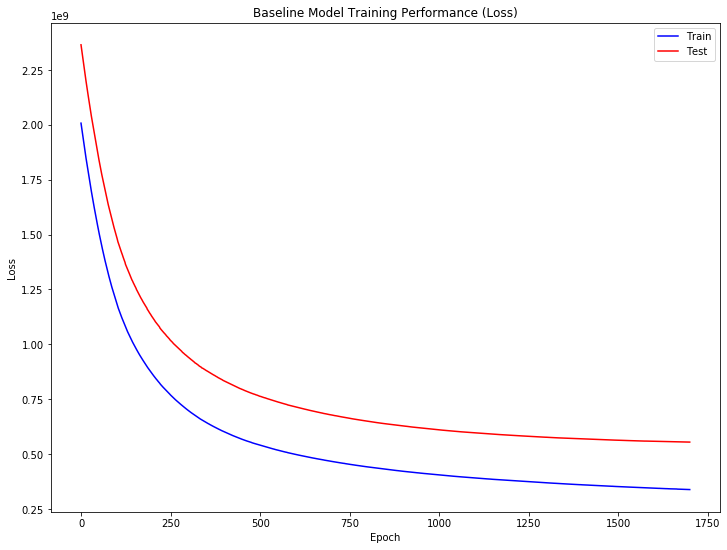

In [36]:
# Define the baseline model with one layer of 64 nodes
def create_baseline_model_1B():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize the baseline model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_1B = create_baseline_model_1B()
extra_epochs = 1500
baseline_hist = baseline_model_1B.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', int(math.sqrt(min(baseline_hist.history['loss']))))
print('The RMSE at the last epoch for the training dataset:', int(math.sqrt(baseline_hist.history['loss'][-1])))
print('The minimum RMSE for the test dataset:', int(math.sqrt(min(baseline_hist.history['val_loss']))))
print('The RMSE at the last epoch for the test dataset:', int(math.sqrt(baseline_hist.history['val_loss'][-1])))
print('Total time for performing model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 300
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

The minimum RMSE for the training dataset: 17449
The RMSE at the last epoch for the training dataset: 17450
The minimum RMSE for the test dataset: 23431
The RMSE at the last epoch for the test dataset: 23466
Total time for performing model fitting: 0:04:13.994988 



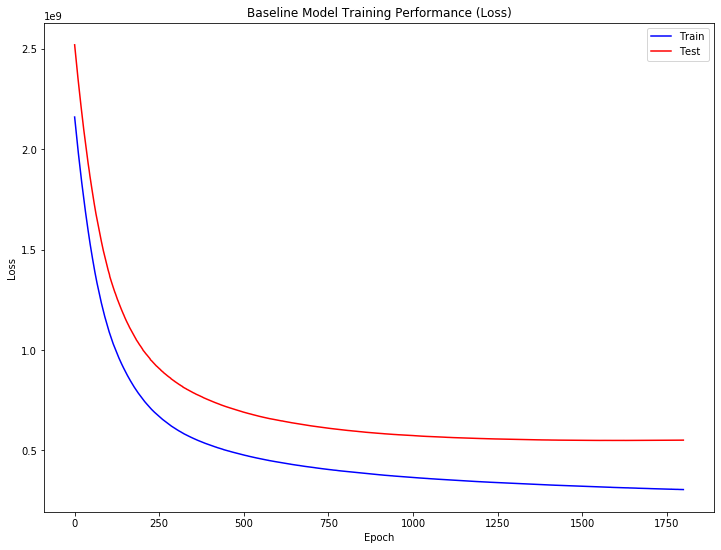

In [37]:
# Define the baseline model with one layer of 128 nodes
def create_baseline_model_1C():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize the baseline model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_1C = create_baseline_model_1C()
extra_epochs = 1500
baseline_hist = baseline_model_1C.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', int(math.sqrt(min(baseline_hist.history['loss']))))
print('The RMSE at the last epoch for the training dataset:', int(math.sqrt(baseline_hist.history['loss'][-1])))
print('The minimum RMSE for the test dataset:', int(math.sqrt(min(baseline_hist.history['val_loss']))))
print('The RMSE at the last epoch for the test dataset:', int(math.sqrt(baseline_hist.history['val_loss'][-1])))
print('Total time for performing model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 200
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

The minimum RMSE for the training dataset: 16781
The RMSE at the last epoch for the training dataset: 16804
The minimum RMSE for the test dataset: 23542
The RMSE at the last epoch for the test dataset: 24045
Total time for model fitting: 0:02:11.728540 



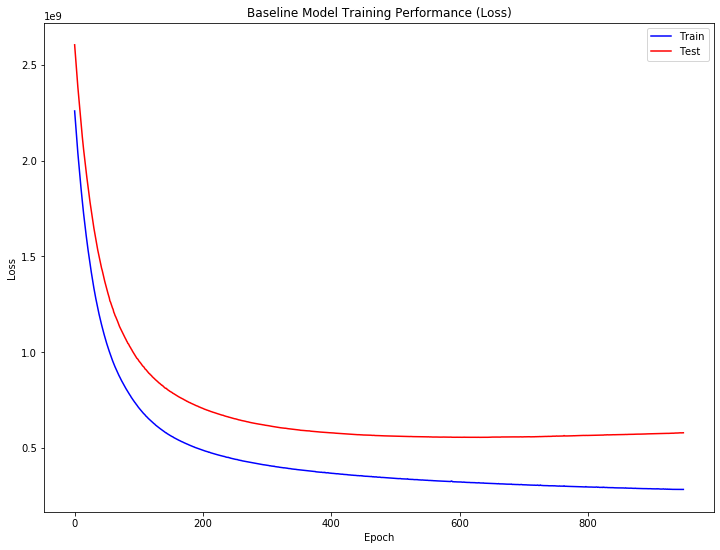

In [38]:
# Define the baseline model with two layers of 32/16 nodes
def create_baseline_model_2A():
    default_model = Sequential()
    default_model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize the baseline model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_2A = create_baseline_model_2A()
extra_epochs = 500
baseline_hist = baseline_model_2A.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', int(math.sqrt(min(baseline_hist.history['loss']))))
print('The RMSE at the last epoch for the training dataset:', int(math.sqrt(baseline_hist.history['loss'][-1])))
print('The minimum RMSE for the test dataset:', int(math.sqrt(min(baseline_hist.history['val_loss']))))
print('The RMSE at the last epoch for the test dataset:', int(math.sqrt(baseline_hist.history['val_loss'][-1])))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 50
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

The minimum RMSE for the training dataset: 15673
The RMSE at the last epoch for the training dataset: 15718
The minimum RMSE for the test dataset: 23581
The RMSE at the last epoch for the test dataset: 26137
Total time for performing model fitting: 0:02:10.578693 



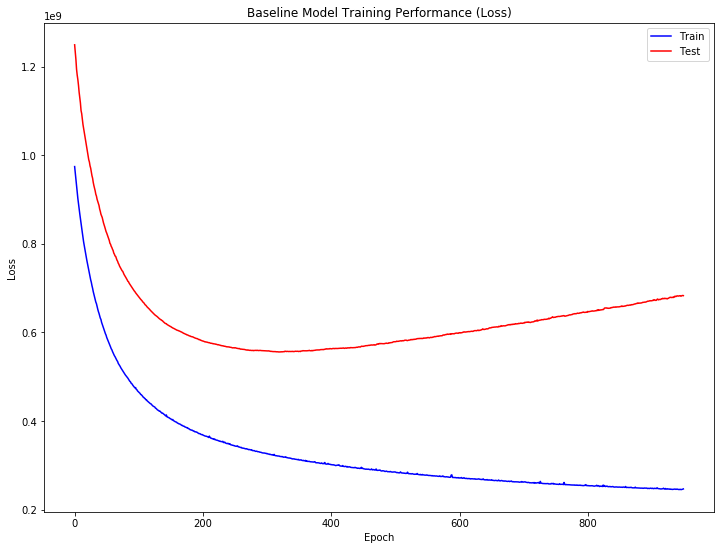

In [39]:
# Define the baseline model with two layers of 64/32 nodes
def create_baseline_model_2B():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize the baseline model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_2B = create_baseline_model_2B()
extra_epochs = 500
baseline_hist = baseline_model_2B.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', int(math.sqrt(min(baseline_hist.history['loss']))))
print('The RMSE at the last epoch for the training dataset:', int(math.sqrt(baseline_hist.history['loss'][-1])))
print('The minimum RMSE for the test dataset:', int(math.sqrt(min(baseline_hist.history['val_loss']))))
print('The RMSE at the last epoch for the test dataset:', int(math.sqrt(baseline_hist.history['val_loss'][-1])))
print('Total time for performing model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 50
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

The minimum RMSE for the training dataset: 13766
The RMSE at the last epoch for the training dataset: 13844
The minimum RMSE for the test dataset: 22708
The RMSE at the last epoch for the test dataset: 24052
Total time for performing model fitting: 0:01:05.941741 



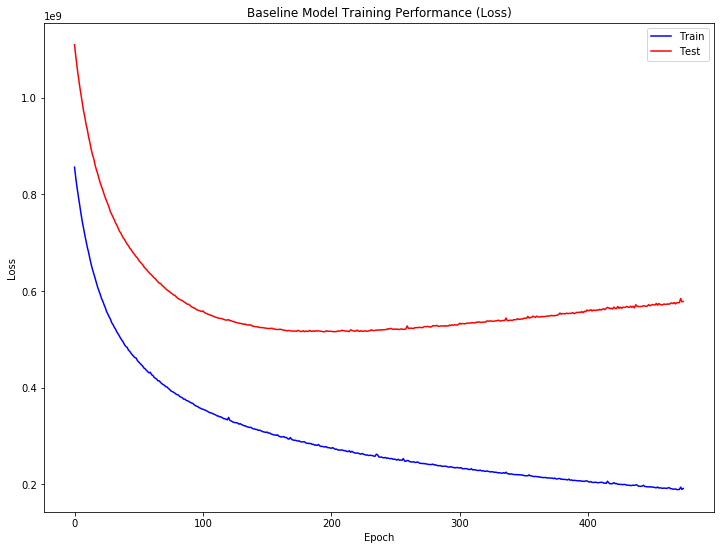

In [40]:
# Define the baseline model with two layers of 128/64 nodes
def create_baseline_model_2C():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize the baseline model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_2C = create_baseline_model_2C()
extra_epochs = 0
baseline_hist = baseline_model_2C.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', int(math.sqrt(min(baseline_hist.history['loss']))))
print('The RMSE at the last epoch for the training dataset:', int(math.sqrt(baseline_hist.history['loss'][-1])))
print('The minimum RMSE for the test dataset:', int(math.sqrt(min(baseline_hist.history['val_loss']))))
print('The RMSE at the last epoch for the test dataset:', int(math.sqrt(baseline_hist.history['val_loss'][-1])))
print('Total time for performing model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 25
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

The minimum RMSE for the training dataset: 16336
The RMSE at the last epoch for the training dataset: 16433
The minimum RMSE for the test dataset: 23718
The RMSE at the last epoch for the test dataset: 24912
Total time for performing model fitting: 0:01:08.140504 



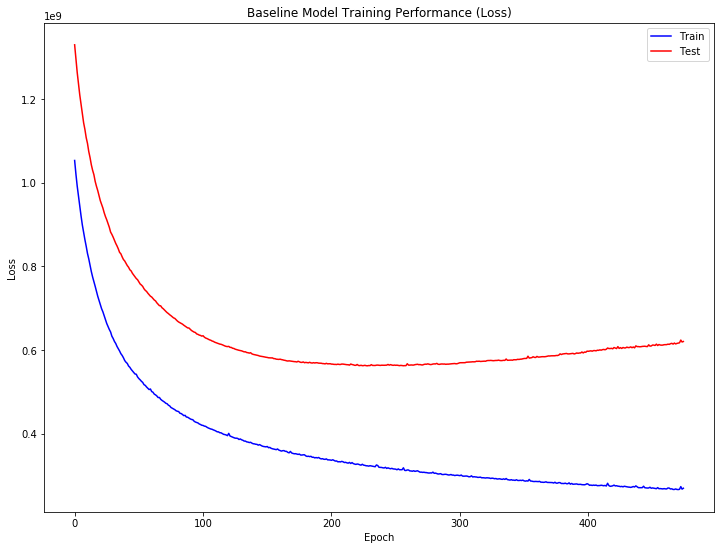

In [41]:
# Define the baseline model with three layers of 32/16/8 nodes
def create_baseline_model_3A():
    default_model = Sequential()
    default_model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize the baseline model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_3A = create_baseline_model_3A()
extra_epochs = 0
baseline_hist = baseline_model_3A.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', int(math.sqrt(min(baseline_hist.history['loss']))))
print('The RMSE at the last epoch for the training dataset:', int(math.sqrt(baseline_hist.history['loss'][-1])))
print('The minimum RMSE for the test dataset:', int(math.sqrt(min(baseline_hist.history['val_loss']))))
print('The RMSE at the last epoch for the test dataset:', int(math.sqrt(baseline_hist.history['val_loss'][-1])))
print('Total time for performing model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 25
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

The minimum RMSE for the training dataset: 14026
The RMSE at the last epoch for the training dataset: 14153
The minimum RMSE for the test dataset: 23365
The RMSE at the last epoch for the test dataset: 25724
Total time for performing model fitting: 0:01:08.118374 



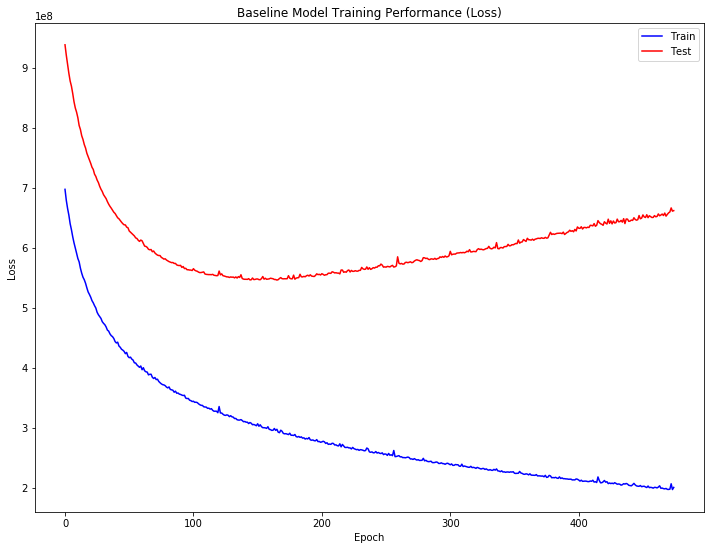

In [42]:
# Define the baseline model with three layers of 64/32/16 nodes
def create_baseline_model_3B():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize the baseline model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_3B = create_baseline_model_3B()
extra_epochs = 0
baseline_hist = baseline_model_3B.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', int(math.sqrt(min(baseline_hist.history['loss']))))
print('The RMSE at the last epoch for the training dataset:', int(math.sqrt(baseline_hist.history['loss'][-1])))
print('The minimum RMSE for the test dataset:', int(math.sqrt(min(baseline_hist.history['val_loss']))))
print('The RMSE at the last epoch for the test dataset:', int(math.sqrt(baseline_hist.history['val_loss'][-1])))
print('Total time for performing model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 25
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

The minimum RMSE for the training dataset: 11342
The RMSE at the last epoch for the training dataset: 11371
The minimum RMSE for the test dataset: 22902
The RMSE at the last epoch for the test dataset: 26865
Total time for performing model fitting: 0:01:08.022215 



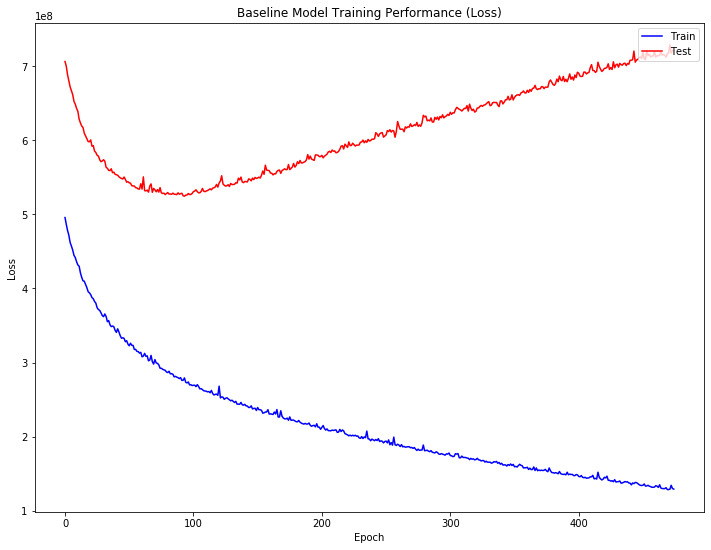

In [43]:
# Define the baseline model with three layers of 128/64/32 nodes
def create_baseline_model_3C():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize the baseline model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_3C = create_baseline_model_3C()
extra_epochs = 0
baseline_hist = baseline_model_3C.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', int(math.sqrt(min(baseline_hist.history['loss']))))
print('The RMSE at the last epoch for the training dataset:', int(math.sqrt(baseline_hist.history['loss'][-1])))
print('The minimum RMSE for the test dataset:', int(math.sqrt(min(baseline_hist.history['val_loss']))))
print('The RMSE at the last epoch for the test dataset:', int(math.sqrt(baseline_hist.history['val_loss'][-1])))
print('Total time for performing model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 25
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 4 Explore Different Baseline Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [0]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [46]:
# Display a summary of the final model
final_model = baseline_model_2C
print(final_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               83840     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 92,161
Trainable params: 92,161
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_5', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_12', 'trainable': True, 'batch_input_shape': (None, 654), 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_13', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', '

In [0]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [49]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:21:57.223164
